## Price movement from 1:00PM to 2:45PM

In [210]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [211]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [212]:
data2 = dataset.copy()

In [213]:
def cal_high_morning(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1130]
  return tick.max()

def cal_high_afternoon(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1255]
  return tick.max()


def cal_low_morning(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1130]
  return tick.min()


def cal_low_afternoon(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1255]
  return tick.min()

def cal_1130_price(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1130]
  if not tick.empty:
    return tick[0]

In [214]:
data_tmp = dataset.copy()
data_tmp['morning_high'] = data_tmp.High
data_tmp['morning_low'] = data_tmp.Low
data_tmp['afternoon_high'] = data_tmp.High
data_tmp['afternoon_low'] = data_tmp.Low
data_tmp['Day_Close'] = data_tmp.Close
data_tmp['price_1130'] = data_tmp.Close
day_data = data_tmp.resample("D").agg({
    'morning_high':cal_high_morning,
    'morning_low': cal_low_morning,
    'afternoon_high':cal_high_afternoon,
    'afternoon_low': cal_low_afternoon,
    'price_1130': cal_1130_price,
    'Day_Close': 'last'
    })
day_data = day_data.dropna()

In [215]:
data = dataset.copy()

In [216]:
data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")
data.drop(columns=['Volume', 'time_d'], inplace=True)

In [217]:
len(data)

75400

In [218]:
# Check invalid data
invalid_data = data[(data.Close == data.afternoon_low) | (data['price_1130'] == data.morning_low) | (data['price_1130'] == data.morning_high)]
len(invalid_data)

2246

In [219]:
# Drop invalid data
data = data[(data.Close != data.afternoon_low) & (data['price_1130'] != data.morning_low) & (data['price_1130'] != data.morning_high)]

In [220]:
# Drop all morning data
data = data[100 * data.index.hour + data.index.minute > 1130]

In [221]:
data['rate_x'] = (data.Close - data.price_1130) / (data.morning_high - data.price_1130)
data['rate_y'] = (data.Close - data.price_1130) / (data.price_1130 - data.morning_low)
data['return'] = (data.afternoon_high - data.Close) / (data.Close - data.afternoon_low)

In [222]:
data.dropna(inplace=True)

In [223]:
data_test = data.copy()
data_test = data_test[data_test.index > '2024-01-01 00:00:00']

In [224]:
### Ignore this year data => tranh over fitting
data = data[data.index < '2024-01-01 00:00:00']

In [225]:
data

,Open,High,Low,Close,morning_high,morning_low,afternoon_high,afternoon_low,price_1130,Day_Close,return,rate_x,rate_y
Date,,,,,,,,,,,,,
2018-08-13 13:00:00,947.5,947.9,947.2,947.5,947.0,942.3,954.6,946.7,947.3,954.2,8.875000,-0.666667,0.040000
2018-08-13 13:05:00,947.6,948.8,947.6,948.0,947.0,942.3,954.6,946.7,947.3,954.2,5.076923,-2.333333,0.140000
2018-08-13 13:10:00,948.0,948.7,947.3,948.7,947.0,942.3,954.6,946.7,947.3,954.2,2.950000,-4.666667,0.280000
2018-08-13 13:15:00,948.5,948.9,947.8,948.2,947.0,942.3,954.6,946.7,947.3,954.2,4.266667,-3.000000,0.180000
2018-08-13 13:20:00,948.0,948.5,947.7,947.7,947.0,942.3,954.6,946.7,947.3,954.2,6.900000,-1.333333,0.080000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 14:15:00,1133.8,1136.5,1132.4,1132.9,1138.0,1132.0,1139.5,1130.9,1137.2,1134.6,3.300000,-5.375000,-0.826923
2023-12-29 14:20:00,1132.4,1133.7,1131.5,1133.3,1138.0,1132.0,1139.5,1130.9,1137.2,1134.6,2.583333,-4.875000,-0.750000
2023-12-29 14:25:00,1133.5,1134.9,1132.2,1133.9,1138.0,1132.0,1139.5,1130.9,1137.2,1134.6,1.866667,-4.125000,-0.634615


In [226]:
data['return'].describe()

count    25761.000000
mean         2.334590
std          6.205325
min          0.000000
25%          0.366667
50%          0.912088
75%          2.261538
max        328.000000
Name: return, dtype: float64

In [227]:
data['return_group'] = pd.cut(data['return'], 35)
r1 = data.groupby(['return_group'])[['return']].count()
r11 = r1[['return']].rename(columns={'return': 'count'})
r11

,count
return_group,
"(-0.328, 9.371]",24716
"(9.371, 18.743]",700
"(18.743, 28.114]",181
"(28.114, 37.486]",59
"(37.486, 46.857]",29
"(46.857, 56.229]",18
"(56.229, 65.6]",15
"(65.6, 74.971]",8
"(74.971, 84.343]",7


In [228]:
# Think about drop the outlier data

In [229]:
data = data[data['return'] < 66]

In [230]:
data['rate_x'].describe()

count    25718.000000
mean        -0.102569
std          9.920288
min       -226.000000
25%         -0.714286
50%          0.034483
75%          0.780227
max        251.000000
Name: rate_x, dtype: float64

In [231]:
data['rate_y'].describe()

count    25718.000000
mean        -0.097565
std          7.954347
min       -177.000000
25%         -0.709302
50%          0.019231
75%          0.769894
max        159.500000
Name: rate_y, dtype: float64

In [232]:
data['rate_x_group'] = pd.qcut(data.rate_x, 25)
data['rate_y_group'] = pd.qcut(data.rate_y, 30)

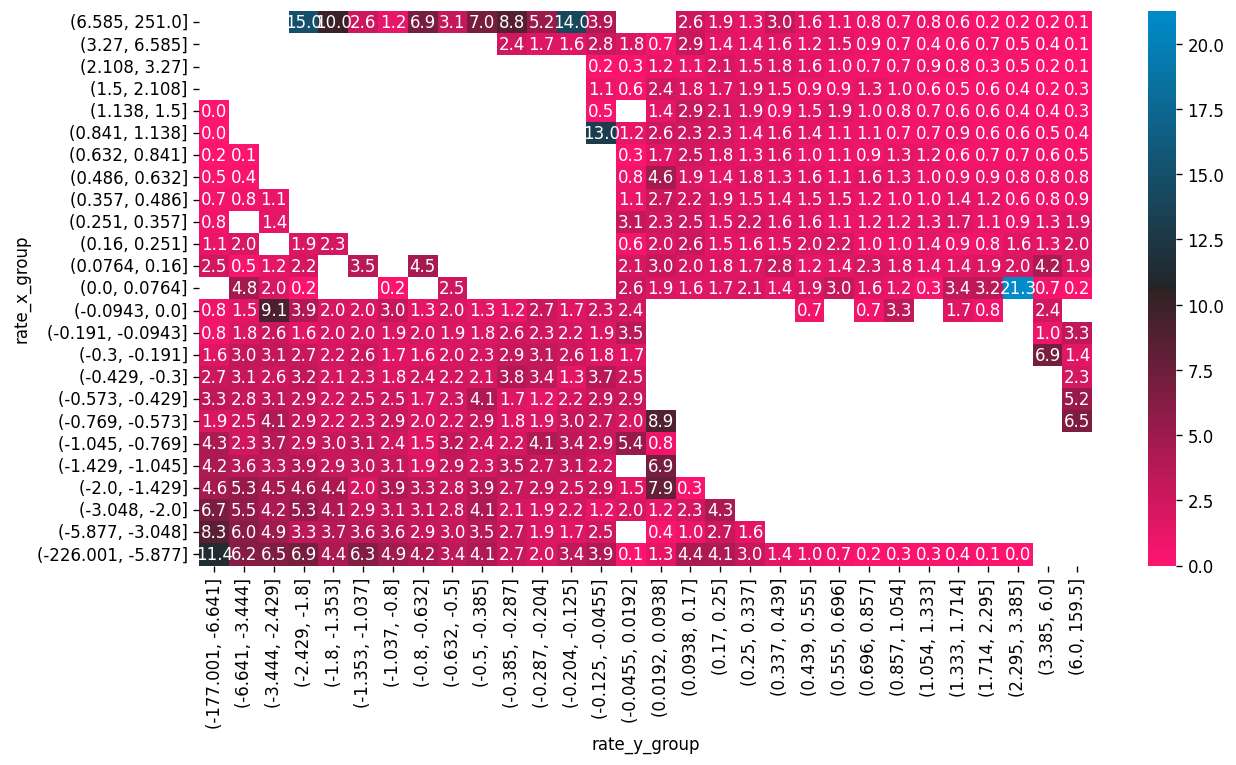

In [233]:
grpd = data.groupby(['rate_x_group', 'rate_y_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='rate_x_group', columns='rate_y_group', values='return').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

In [234]:
# Short = data_test[(((data_test.rate_x > 0.837) & (data_test.rate_x < 1.51) & (data_test.rate_y > -177) & (data_test.rate_y < -6.7)) | ((data_test.rate_x > 6) & (data_test.rate_y > 2.1)))]
# Long = data_test[(((data_test.rate_x < -6) & (data_test.rate_y < 0.81)) | ((data_test.rate_x < -3.1) & (data_test.rate_y < -2.5)) | ((data_test.rate_x < -2) & (data_test.rate_y < 3.5)))]

In [235]:
# def cal_signal(row):
#     signal = ''
#     if (0.837 < row['rate_x'] < 1.51 and row['rate_y'] < -6.7) or (2.1 < row['rate_x'] and 6< row['rate_y']):
#         signal = 'short'
#     if (row['rate_x'] < -3 and row['rate_y'] < -6.6) or (row['rate_x'] < -3.1 and row['rate_y'] < -2.5) or (row['rate_x'] < -2 and row['rate_y'] < 3.5):
#         signal = 'long'
#     return signal

In [236]:
# data_test['signal'] = data_test.apply(lambda r: cal_signal(r), axis=1)

In [237]:
# k = data_test[data_test['signal'] != '']

In [238]:
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(k)

In [239]:
import xgboost as xg 
from sklearn.metrics import mean_squared_error as MSE

In [240]:
feature_cols = ["rate_x", "rate_y"]
# Splitting 
X_train = data[feature_cols]
y_train = data[['return']]
X_test = data_test[feature_cols]
y_test = data_test[['return']]
  
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 100, seed = 123)
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [242]:
# Predict the model 
y_pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test, y_pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  6.334207


In [243]:
X_result = X_test.copy()
X_result = X_result.assign(Predicts=y_pred)
X_result = X_result[['Predicts']]
data_test = pd.merge(data_test, X_result, left_index=True, right_index=True, how="left")
data_test.dropna(inplace=True)

In [244]:
data_test

,Open,High,Low,Close,morning_high,morning_low,afternoon_high,afternoon_low,price_1130,Day_Close,return,rate_x,rate_y,Predicts
Date,,,,,,,,,,,,,,
2024-01-02 13:00:00,1132.6,1134.0,1132.6,1133.5,1141.8,1131.0,1135.8,1131.3,1132.6,1133.5,1.045455,0.097826,0.562500,1.838049
2024-01-02 13:05:00,1133.5,1134.0,1133.0,1133.1,1141.8,1131.0,1135.8,1131.3,1132.6,1133.5,1.500000,0.054348,0.312500,2.049227
2024-01-02 13:10:00,1133.1,1134.1,1133.1,1133.7,1141.8,1131.0,1135.8,1131.3,1132.6,1133.5,0.875000,0.119565,0.687500,1.859101
2024-01-02 13:15:00,1133.7,1134.1,1132.9,1133.6,1141.8,1131.0,1135.8,1131.3,1132.6,1133.5,0.956522,0.108696,0.625000,1.481426
2024-01-02 13:20:00,1133.7,1134.2,1133.1,1134.2,1141.8,1131.0,1135.8,1131.3,1132.6,1133.5,0.551724,0.173913,1.000000,1.231180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-19 14:15:00,1301.2,1301.6,1298.3,1299.5,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,1.238095,-0.344828,-2.142857,2.558902
2024-07-19 14:20:00,1299.1,1301.8,1295.3,1301.6,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.492063,-0.103448,-0.642857,2.285667
2024-07-19 14:25:00,1302.4,1302.6,1300.1,1302.2,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.362319,-0.034483,-0.214286,10.146679


In [249]:
def cal_signal(row):
    signal = ''
    if row['return_shift_2'] < row['return_shift_1'] < row['Predicts']:
        signal = 'long'
    elif row['return_shift_2'] > row['return_shift_1'] > row['Predicts']:
        signal = 'short'
    return signal

In [250]:
data_test['return_shift_1'] = data_test['return'].shift(1)
data_test['return_shift_2'] = data_test['return'].shift(2)
data_test['signal'] = data_test.apply(lambda r: cal_signal(r), axis=1)

In [251]:
data_test[data_test.index > '2024-07-18 08:45:00']

,Open,High,Low,Close,morning_high,morning_low,afternoon_high,afternoon_low,price_1130,Day_Close,return,rate_x,rate_y,Predicts,return_shift_1,return_shift_2,signal
Date,,,,,,,,,,,,,,,,,
2024-07-19 13:00:00,1302.6,1303.0,1301.1,1302.3,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.342857,-0.022989,-0.142857,1.310847,0.062500,0.030303,long
2024-07-19 13:05:00,1302.3,1303.1,1302.0,1302.9,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.236842,0.045977,0.285714,1.411862,0.342857,0.062500,long
2024-07-19 13:10:00,1303.0,1303.3,1300.5,1300.7,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.740741,-0.206897,-1.285714,2.438175,0.236842,0.342857,
2024-07-19 13:15:00,1300.6,1301.7,1300.6,1300.9,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.678571,-0.183908,-1.142857,1.750540,0.740741,0.236842,long
2024-07-19 13:20:00,1300.9,1301.9,1299.7,1301.9,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.424242,-0.068966,-0.428571,2.002134,0.678571,0.740741,
2024-07-19 13:25:00,1301.7,1303.4,1301.0,1303.4,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.160494,0.103448,0.642857,1.481426,0.424242,0.678571,
2024-07-19 13:30:00,1303.1,1303.6,1302.7,1303.0,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.220779,0.057471,0.357143,1.972192,0.160494,0.424242,
2024-07-19 13:35:00,1303.0,1303.1,1301.5,1301.8,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.446154,-0.080460,-0.500000,1.341749,0.220779,0.160494,long
2024-07-19 13:40:00,1301.8,1301.8,1299.1,1300.2,1311.2,1301.1,1304.7,1295.3,1302.5,1297.1,0.918367,-0.264368,-1.642857,2.072535,0.446154,0.220779,long
